In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error

from datetime import datetime, timedelta
from itertools import product

import utils

In [2]:
# read csv
bandwidth = pd.read_csv('data/bandwidth.csv')
bandwidth.columns = ['bandwidth']
# input hourly dates starting from 2019/01/01
inital_date = datetime(2000, 1, 1, 0, 0, 0)
hourly_delta = timedelta(hours=1)

hourly_dates = []
for i in range(bandwidth.shape[0]):
    hourly_dates.append((i * hourly_delta) + inital_date)
    
bandwidth['date'] = pd.to_datetime(hourly_dates)
bandwidth.set_index('date', inplace=True)
bandwidth.index.freq = 'H'
bandwidth.head()


,bandwidth
date,
2000-01-01 00:00:00,1000.496714
2000-01-01 01:00:00,1000.969408
2000-01-01 02:00:00,1002.046019
2000-01-01 03:00:00,1004.702118
2000-01-01 04:00:00,1007.447816


In [3]:
bandwidth.shape

(10000, 1)

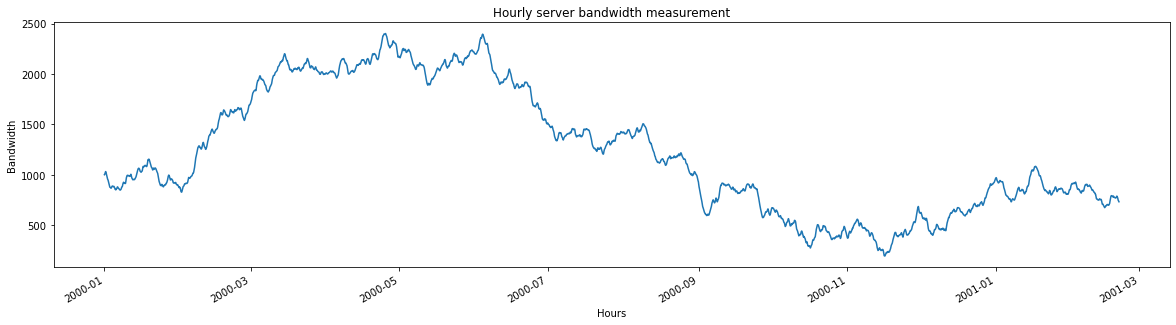

In [4]:
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(bandwidth['bandwidth'])
ax.set_ylabel('Bandwidth')
ax.set_xlabel('Hours')

plt.title('Hourly server bandwidth measurement')

fig.autofmt_xdate()
plt.show()

### Test stationarity

In [5]:
adf_test = adfuller(bandwidth.bandwidth)
print('Stationary' if adf_test[1] < 0.05 else 'Non stationary')

Non stationary


In [6]:
bandwidth['diff_bandwidth'] = bandwidth['bandwidth'].diff()

In [7]:
adf_test1 = adfuller(bandwidth.diff_bandwidth[1:])
print('Stationary' if adf_test1[1] < 0.05 else 'Non stationary')

Stationary


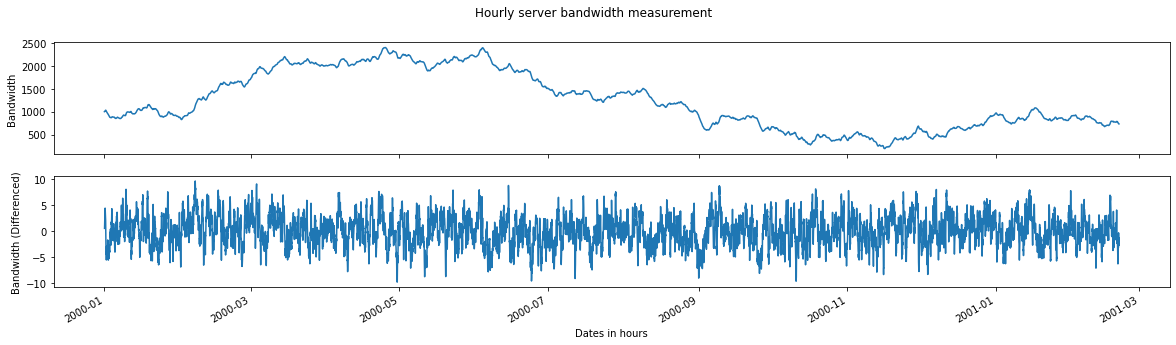

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(20,5))
fig.suptitle('Hourly server bandwidth measurement')

ax1.plot(bandwidth['bandwidth'])
ax1.set_ylabel('Bandwidth')
ax1.set_xlabel('Hours')

ax2.plot(bandwidth['diff_bandwidth'])
ax2.set_ylabel('Bandwidth (Differenced)')
ax2.set_xlabel('Dates in hours')

fig.autofmt_xdate()
plt.show()

### Create test and training sets

In [9]:
test_set_size = 168 # one week worth for forecasting

df = bandwidth[1:].copy()

train, test = train_test_split(df, test_size=test_set_size)

print(len(train))
print(len(test))

9831
168


### Use auto_arima to get the best value of arima_order

In [29]:
opt_arima = auto_arima(train.diff_bandwidth, 
                       start_p=0, start_q=0, 
                       max_p=5, max_q=5, max_order=10,
                       seasonal=False, information_criterion='aic',
                       suppress_warnings=True, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29269.913, Time=0.17 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=28669.193, Time=0.47 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=28652.546, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29267.916, Time=0.11 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=28641.819, Time=1.09 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=6.69 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28538.121, Time=2.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=28626.553, Time=0.83 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.85 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=8.41 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=28450.277, Time=1.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=28446.278, Time=1.36 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=10.01 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=28383.689, Time=1.78 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=12.00 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=28381.693, Time=0.79 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=28444.281, Time=0.64 sec


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=inf, Time=3.65 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=inf, Time=3.39 sec

Best model:  ARIMA(0,1,5)(0,0,0)[0]          
Total fit time: 63.366 seconds


/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


### We pick the best performing order and use the order

In [32]:
arima_order = opt_arima.order
arima_model = ARIMA(df.diff_bandwidth, order=arima_order).fit()
res = arima_model.resid

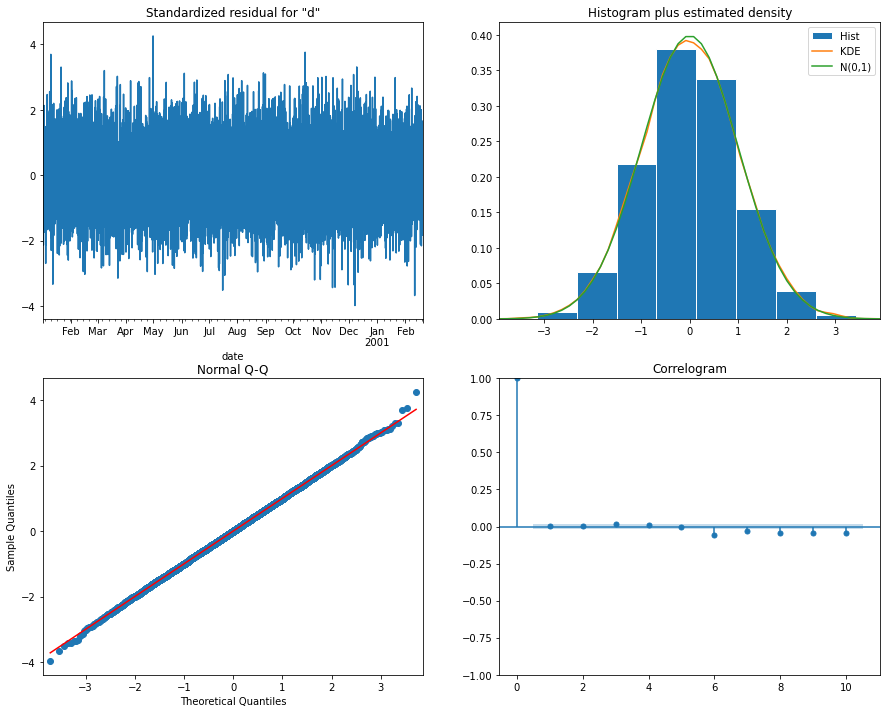

In [13]:
arima_model.plot_diagnostics(figsize=(15, 12));

In [14]:
# using the ljuncbox function to stest that residuals are IID
ljungbox_result = acorr_ljungbox(res, np.arange(1, 20, 1))
print(ljungbox_result)

       lb_stat     lb_pvalue
1     0.292594  5.885631e-01
2     0.762098  6.831444e-01
3     3.434328  3.293800e-01
4     5.021494  2.850992e-01
5     5.021795  4.132261e-01
6    35.287560  3.790436e-06
7    45.529649  1.079150e-07
8    63.475644  9.653300e-11
9    81.319668  8.833760e-14
10  100.811344  3.749200e-17
11  109.232208  2.607423e-18
12  119.043755  9.584786e-20
13  137.992437  5.310645e-23
14  139.862856  7.554577e-23
15  144.106654  3.553694e-23
16  152.188853  2.890298e-24
17  159.439716  3.427396e-25
18  160.021032  8.253378e-25
19  176.734887  1.357494e-27


### 6.6 Forecasting bandwidth usage

In [15]:
def arima_predict_function(arr, arma_order, window):
    arima = ARIMA(arr, order=arma_order)
    fit = arima.fit()
    return fit.get_forecast(steps=window).predicted_mean

total_len = df.shape[0]
train_len = train.shape[0]
window = 2

predict_arma = utils.pd_rolling_forecast(df.diff_bandwidth, total_len, train_len, window, 'ARMA', arima_order, arima_predict_function)
test.loc[:, 'predict_arma'] = predict_arma

test.head()

,bandwidth,diff_bandwidth,predict_arma
date,,,
2001-02-13 16:00:00,717.176939,-5.943995,-5.820270
2001-02-13 17:00:00,711.311745,-5.865194,-5.684636
2001-02-13 18:00:00,708.114679,-3.197066,-5.670841
2001-02-13 19:00:00,707.024482,-1.090197,-5.536666
2001-02-13 20:00:00,707.689774,0.665291,-0.704397


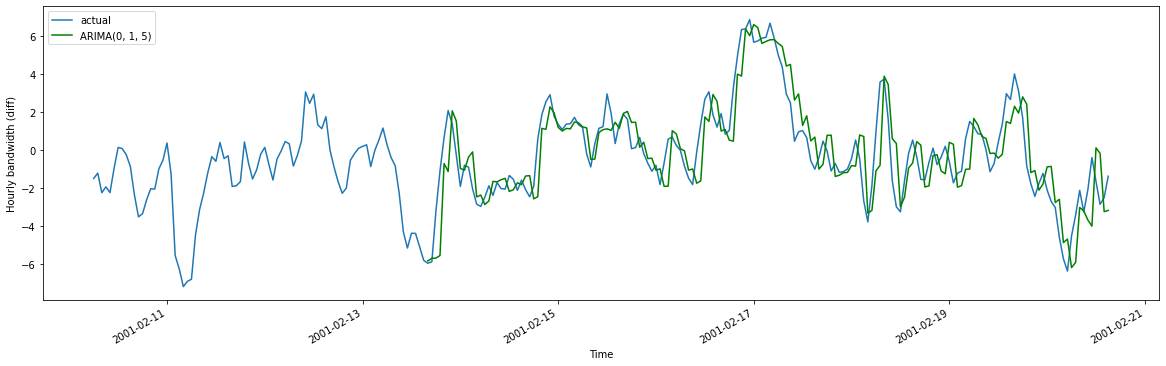

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df.diff_bandwidth[-250:], label='actual')
ax.plot(test.predict_arma, 'g', label=f'ARIMA{arima_order}')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth (diff)')

fig.autofmt_xdate()
plt.show()

In [20]:
mse_arima = mean_squared_error(test.diff_bandwidth, predict_arma)
mse_arima

1.9005895131397883

In [21]:
k = total_len - test.shape[0] + 1
bandwidth['predict_bandwidth'] = bandwidth['bandwidth'].iloc[k] + test['predict_arma'].cumsum()

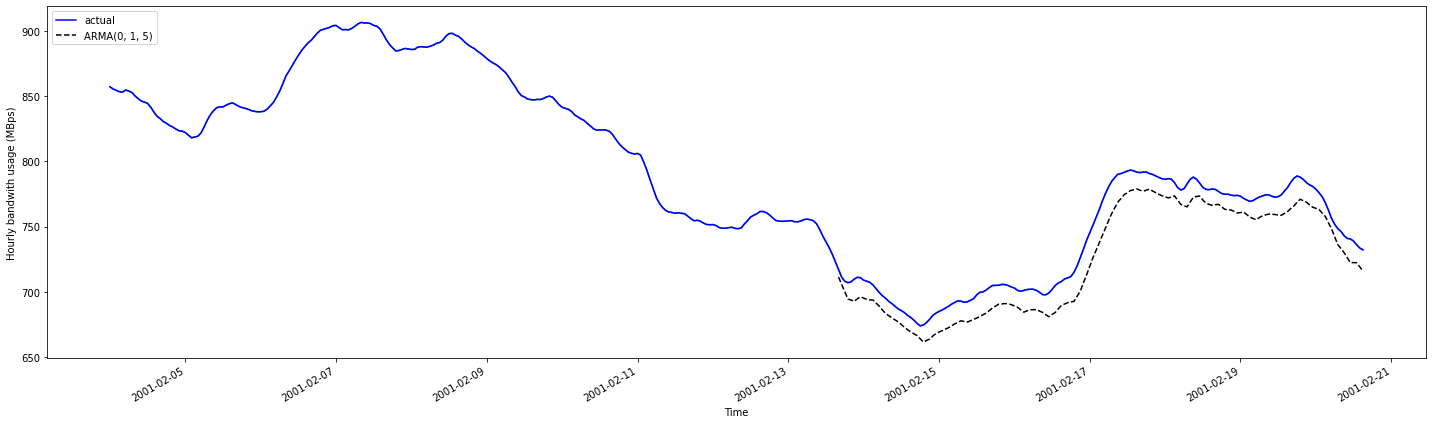

In [22]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(bandwidth['bandwidth'][-400:])
ax.plot(bandwidth['bandwidth'][-400:], 'b-', label='actual')
ax.plot(bandwidth['predict_bandwidth'][-400:], 'k--', label=f'ARMA{arima_order}')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
mae = mean_absolute_error(bandwidth.bandwidth[k:], bandwidth.predict_bandwidth[k:])

print(mae)

15.064614366326902


In [34]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         diff_bandwidth   No. Observations:                 9999
Model:                 ARIMA(0, 1, 5)   Log Likelihood              -14417.612
Date:                Sat, 28 Jan 2023   AIC                          28847.225
Time:                        18:51:07   BIC                          28890.486
Sample:                    01-01-2000   HQIC                         28861.868
                         - 02-20-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2487      0.010     24.714      0.000       0.229       0.268
ma.L2         -0.0064      0.010     -0.623      0.533      -0.027       0.014
ma.L3         -0.1733      0.010    -16.940      0.000      -0.193      -0.153
ma.L4         -0.0629      0.010     -6.193      0.000      -0.083      -0.043
ma.L5         -0.0899      0.010     -9.051      0.000      -0.109      -0.070
sigma2         1.0473      0.015     71.324      0.000       1.018       1.076
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 0.74
Prob(Q):                              0.59   Prob(JB):                         0.69
Heteroskedasticity (H):               1.05   Skew:                             0.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""